# Import modules

In [1]:
#!/usr/bin/pythonpy
################################################################################
# PYTHON's MODULAE
# ------------------------------------------------------------------------------
################################################################################
import os
import sys
module_path = os.path.abspath(os.path.join('/lib/python3.8/site-packages'))
if module_path not in sys.path:
    sys.path.append(module_path)

import fortran_integral
import fortran_quad
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colorbar as colorb
import pickle 
import datetime
from matplotlib import colors

# Total cross sections
import models.sigma0_xsections as sig0
import models.general_parameters as gp
import models.relic_density_calc as ohm
import models.radiative_factorization as hp
import models.pdf_integration as qcd
import utils.colorb_2D as cb2d
import lhapdf  


#################################################
today = datetime.date.today().strftime('%Y-%m-%d')
today = '2023-10-28'

## Some configurations

sigmaz = {}
## Geral parameters
brn = gp.brn
grx0 = gp.grx0 
glx0 = gp.glx0
gx0 = gp.gx0

dmnames = sig0.dmnames
smax = gp.smax
me = gp.mvec[0]

Mmed = gp.Mmed  # TeV
mx  = gp.mx #  0.80 * Mmed/2  DM mass [TeV]
Nf_ee = gp.Nf_ee 
Nf_qq = gp.Nf_qq


---
---
# 1 - $e^{+}e^{-}$ interaction

## Relic

### Data generation

In [8]:
binsize_ohm = 70
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = (Mmed/2)*0.80 # DM mass [TeV]
smax = Mmed**2

gr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

omegarelic_coup = {}
print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(sig0.dmnames):

    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
    
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x)

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x)


    gp.save_obj(omegarelic_coup[dmname], f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_ee_Scalar_binsize_70.pkl
Done for Scalar
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_ee_Fermion_binsize_70.pkl
Done for Fermion
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_ee_Vector_binsize_70.pkl
Done for Vector


### Plot

/mnt/c/Users/Marcio/resonant-dm-relic/notebooks/utils/colorb_2D.py:408: UserWarning: The following kwargs were not used by contour: 'rasterized'
  countour_relic_line = ax[fignumber].contour(gr_grid_ohm, gx_grid_ohm, data_object[dmname][cp]['data'], ohm.planckdata1, colors='k', linewidths=2, linestyles='dashed', rasterized=True)


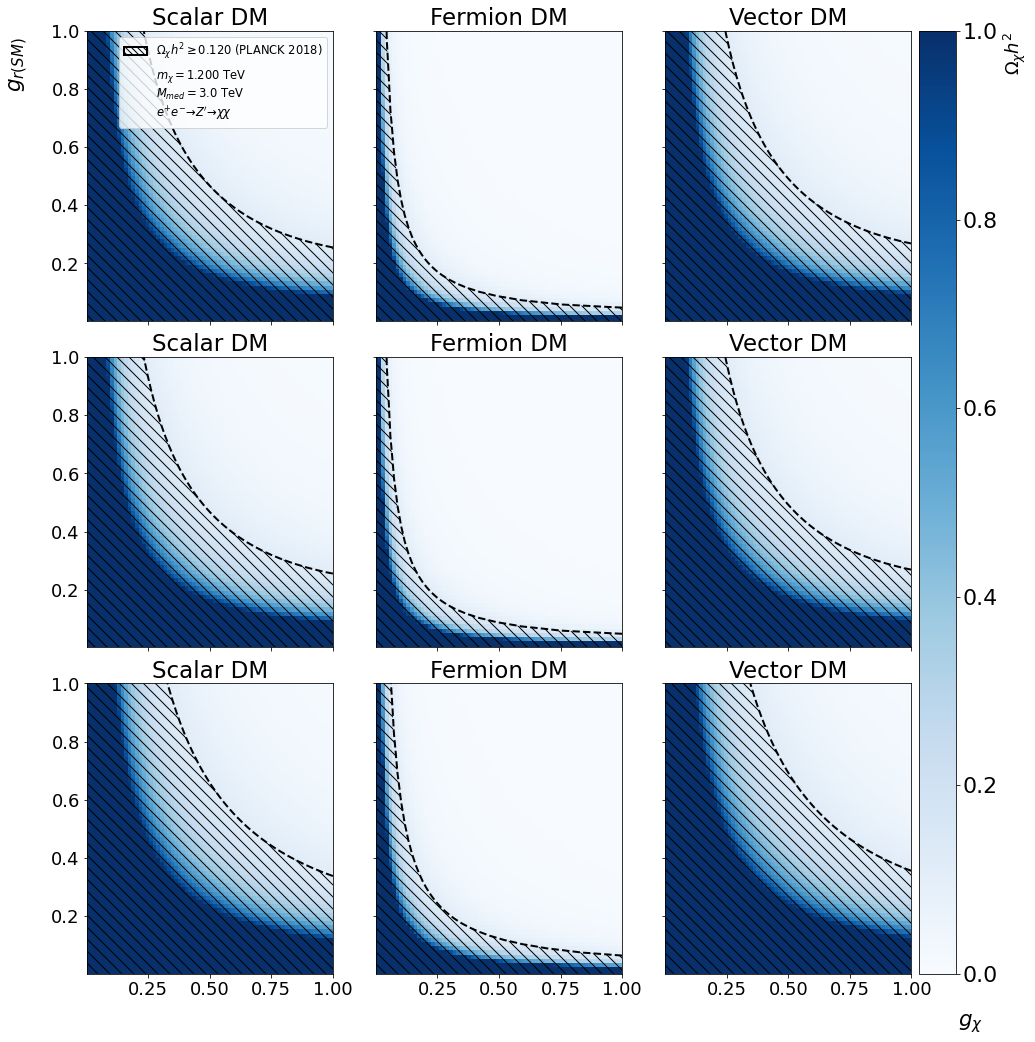

In [2]:
process = 'ee'
binsize_ohm = 70
omegarelic_coup = {}
for dmname in sig0.dmnames:
    omegarelic_coup[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')

cb2d.cb_plot3x3_relic(process, f'7-omega-relic-{process}-coup', omegarelic_coup, sig0.dmnames)

## Couplings

### Data generation

In [9]:
binsize = 100
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = (Mmed/2)*0.80 # DM mass [TeV]
smax = Mmed**2
gr = np.linspace(1E-3, 1.1, binsize) # right SM/DM coupling
gx = np.linspace(1E-3, 1.1, binsize) # DM coupling
# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq

@np.vectorize
def sigmap(s, mq, Mmed, mx, gr, gl, gx, Nf_x):
    sigmatot =  hp.HPhsig(s, mq, Mmed, mx, gr, gl, gx, sig0.SFV(dmname).sig0, Nf_x) 
    return sigmatot 

sigmaz = {}

for fignumber, dmname in enumerate(sig0.dmnames):

    sigmaz[dmname] = {}

    for cp in gp.cps:
    
        sigmaz[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, gr_grid, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, -gr_grid, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, 0, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)


    gp.save_obj(sigmaz[dmname], f'../myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}.pkl')
    print(f'Done for {dmname}')



Doing coupling...


/tmp/ipykernel_3253/4080241678.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)
/tmp/ipykernel_3253/4080241678.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), 

Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_ee_Scalar_binsize_100.pkl
Done for Scalar
Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_ee_Fermion_binsize_100.pkl
Done for Fermion
Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_ee_Vector_binsize_100.pkl
Done for Vector


### Plot

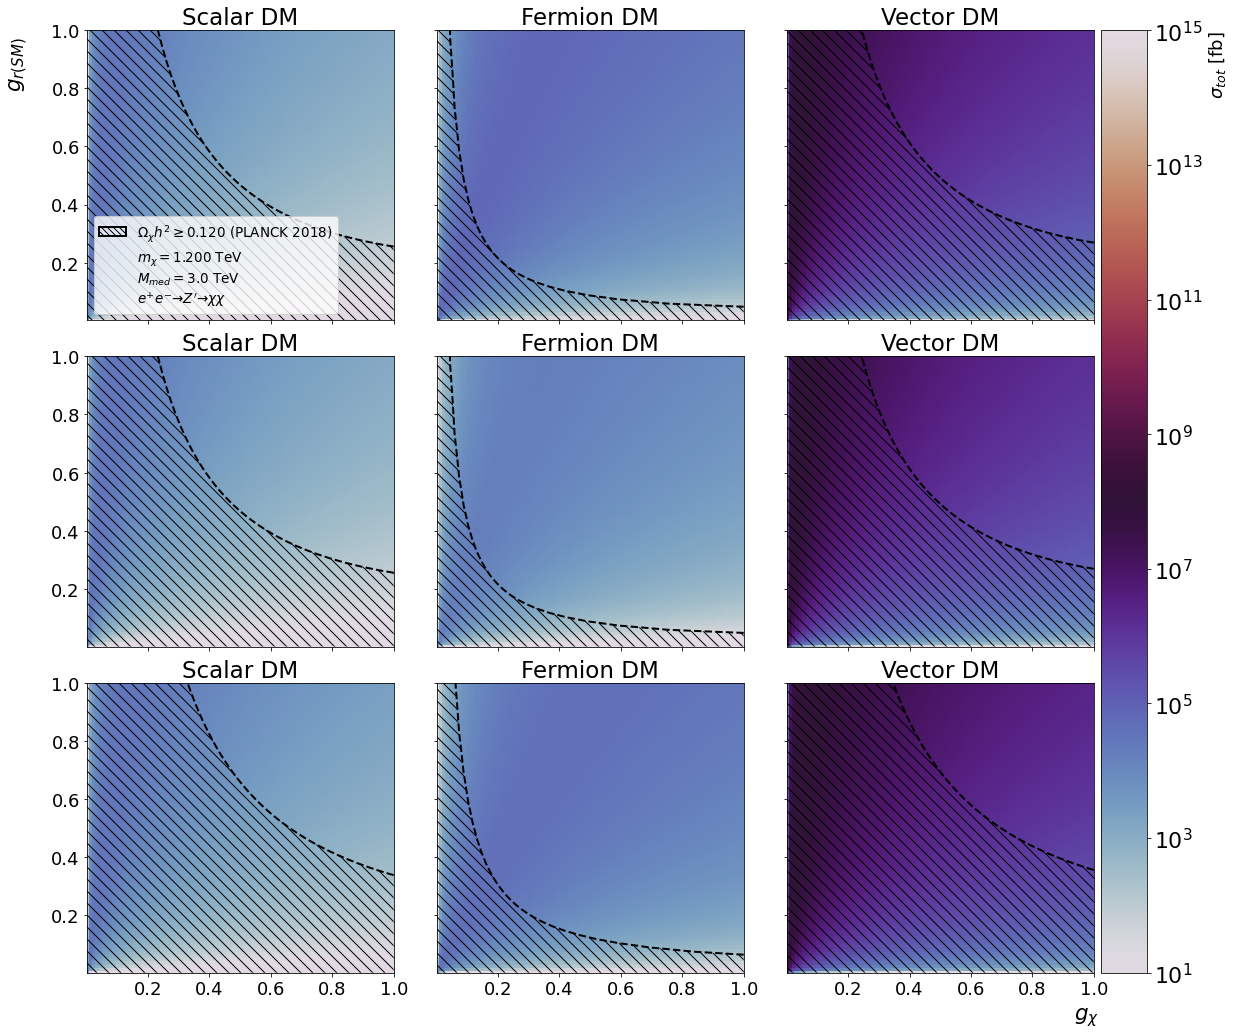

In [3]:
process = 'ee'
binsize_ohm = 70
omegarelic_coup = {}
for dmname in sig0.dmnames:
    omegarelic_coup[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')


binsize = 100
sigmaz = {}
for dmname in sig0.dmnames:
    sigmaz[dmname]  = gp.load_obj(f'../myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}.pkl')

cb2d.cb_plot3x3(process, f'12-coupxcoup-{process}-ISR', sigmaz, omegarelic_coup, sig0.dmnames)

# 2 - $q \bar q$ interaction 

## 2.1 Relic

In [10]:
binsize_ohm = 70
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = (Mmed/2)*0.80 # DM mass [TeV]
smax = Mmed**2

gr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

omegarelic_coup = {}
print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(sig0.dmnames):

    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
    
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x)

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x)


    gp.save_obj(omegarelic_coup[dmname], f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_qq_Scalar_binsize_70.pkl
Done for Scalar
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_qq_Fermion_binsize_70.pkl
Done for Fermion
Objeto salvo em ../myruns/2023-10-28_omegarelic_coup_qq_Vector_binsize_70.pkl
Done for Vector


/mnt/c/Users/Marcio/resonant-dm-relic/notebooks/utils/colorb_2D.py:408: UserWarning: The following kwargs were not used by contour: 'rasterized'
  countour_relic_line = ax[fignumber].contour(gr_grid_ohm, gx_grid_ohm, data_object[dmname][cp]['data'], ohm.planckdata1, colors='k', linewidths=2, linestyles='dashed', rasterized=True)


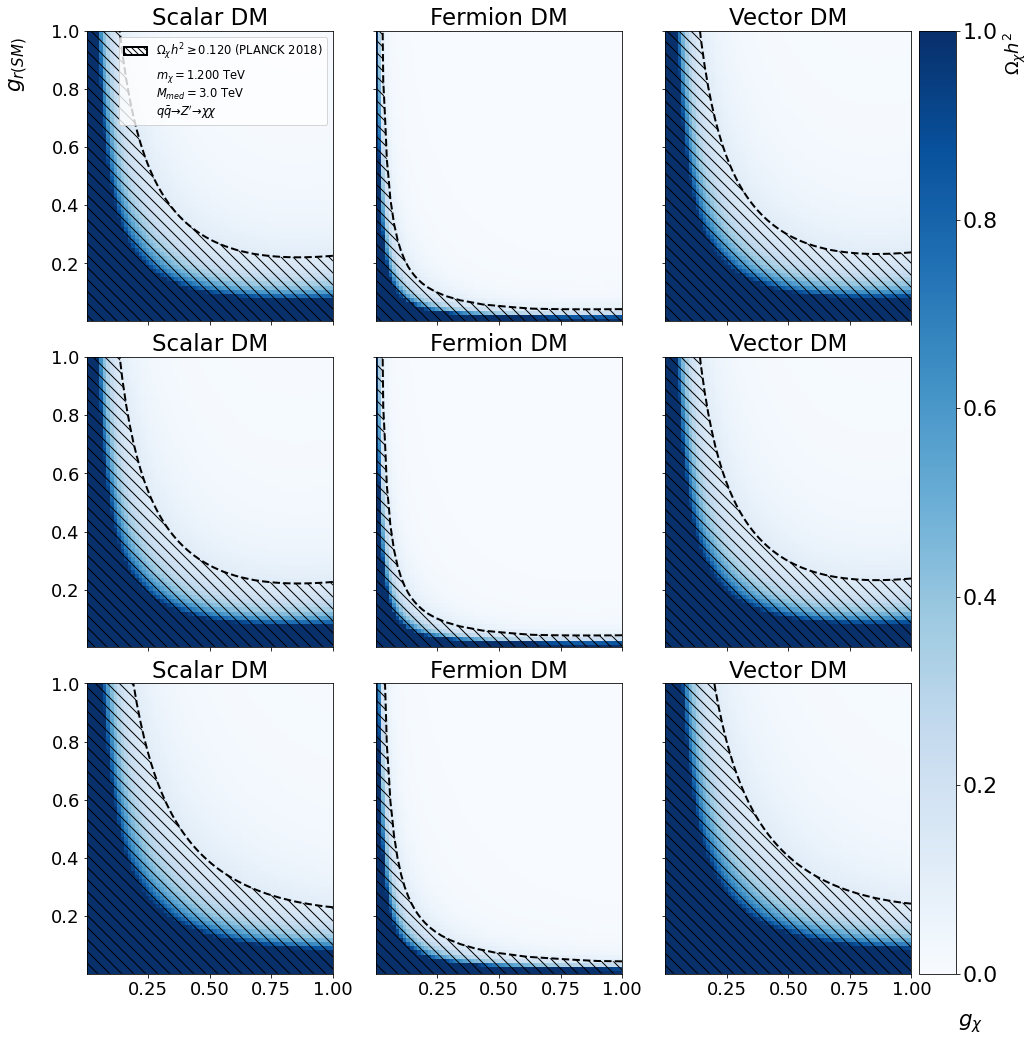

In [4]:
process = 'qq'
binsize_ohm = 70
omegarelic_coup = {}
for dmname in sig0.dmnames:
    omegarelic_coup[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')

cb2d.cb_plot3x3_relic(process, f'8-omega-relic-{process}-coup', omegarelic_coup, sig0.dmnames)

## 2.2 Coupling

### Data generation

## coupling qq - ISR

In [11]:
binsize = 100

gr = np.arange(1E-3, 1.1, 1/binsize) # right SM/DM coupling
gx = np.arange(1E-3, 1.1, 1/binsize) # DM coupling
# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

#define pdf
PDF_sets = ['CT10', 'NNPDF31_lo_as_0118', 'CT18NLO', 'MMHT2014lo68cl', 'PDF4LHC15_nlo_100']
pdf = lhapdf.mkPDF(PDF_sets[1], 0)
s_max = (14)**2 
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
sigmaz = {}
sighat_hphoton = {}

for fignumber, dmname in enumerate(sig0.dmnames):

    sigmaz[dmname] = {}
    sighat_hphoton[dmname] = {}
    sig0funcs = sig0.SFV(dmname).sig0

    for cp in gp.cps:
    
        sigmaz[dmname][cp] = {}
        sighat_hphoton[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, gr_grid, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, gr_grid, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)


        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, -gr_grid, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, -gr_grid, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, 0, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, 0, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)


    gp.save_obj(sigmaz[dmname], f'../myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}.pkl')
    print(f'Done for {dmname}')


LHAPDF 6.5.3 loading /share/LHAPDF/NNPDF31_lo_as_0118/NNPDF31_lo_as_0118_0000.dat
NNPDF31_lo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 315000


/tmp/ipykernel_3253/1756969129.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)
/tmp/ipykernel_3253/1756969129.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'

Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_qq_Scalar_binsize_100.pkl
Done for Scalar
Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_qq_Fermion_binsize_100.pkl
Done for Fermion
Objeto salvo em ../myruns/2023-10-28_sigmaz_coup_qq_Vector_binsize_100.pkl
Done for Vector


In [3]:
mx

1.2000000000000002

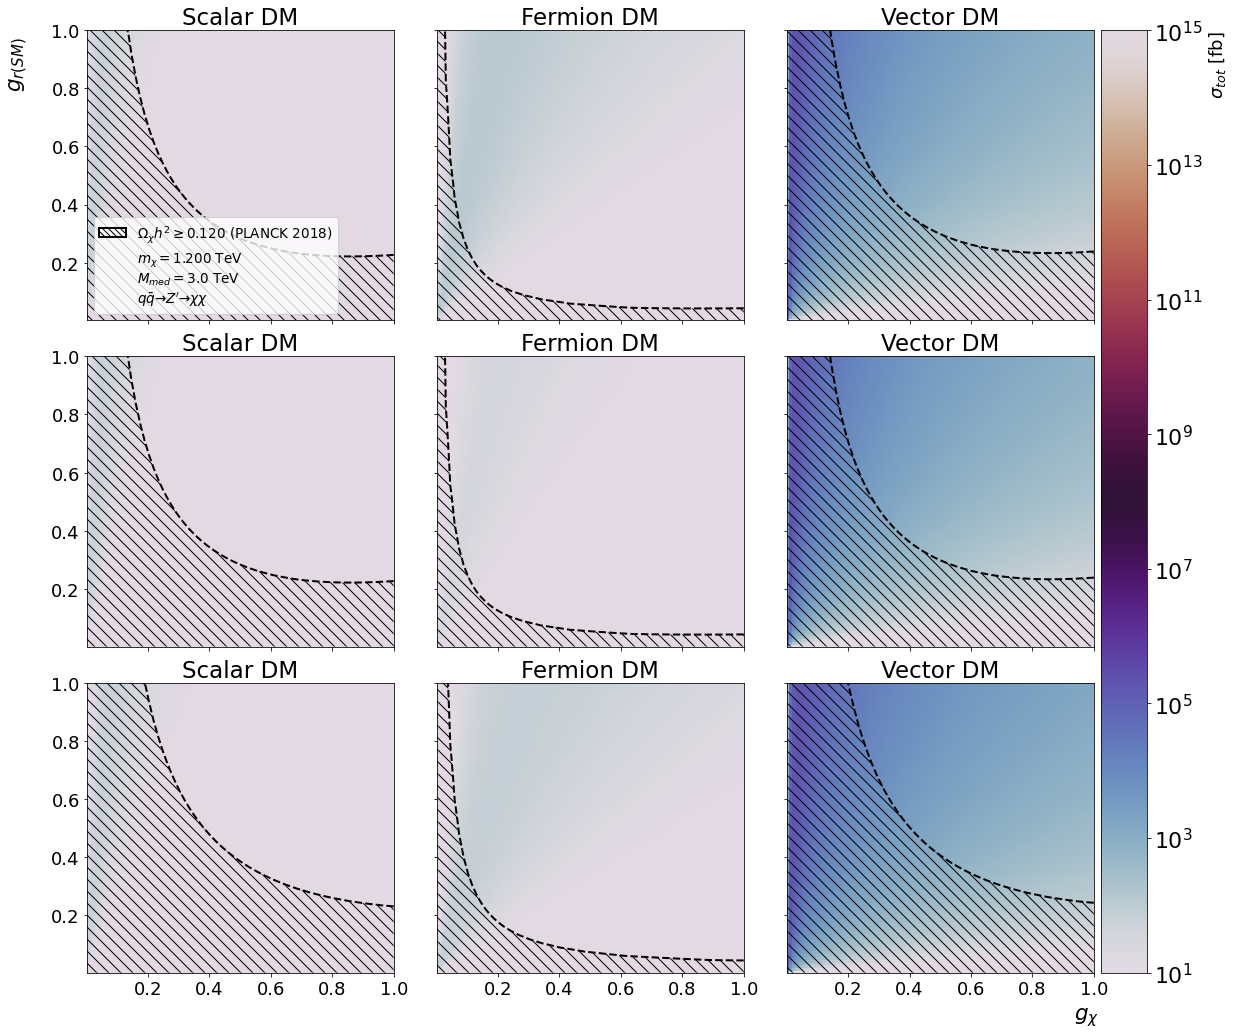

In [2]:
process = 'qq'
binsize_ohm = 70
omegarelic_coup = {}
for dmname in sig0.dmnames:
    omegarelic_coup[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}.pkl')


binsize = 100
sigmaz = {}
for dmname in sig0.dmnames:
    sigmaz[dmname]  = gp.load_obj(f'../myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}.pkl')

cb2d.cb_plot3x3(process, f'13-coupxcoup-{process}-ISR', sigmaz, omegarelic_coup, sig0.dmnames)